<a href="https://colab.research.google.com/github/wang1792/Project1/blob/main/Deep_Double_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import losses, optimizers, metrics
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.data import loadlocal_mnist
from tqdm import tqdm_notebook

In [ ]:
#download MNIST dataset
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  1019k      0 --:--:-- --:--:-- --:--:-- 1044k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0   206M      0 --:--:-- --:--:-- --:--:--  210M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0   200k      0 --:--:-- --:--:-- --:--:--  201k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  50.1M      0 --:--:-- --:--:-- --:--:-- 50.7M


In [ ]:
#unzip files
!gunzip t*-ubyte.gz

In [ ]:
def add_noise(images, noise_ratio,num_cols):
  # num_rows,num_cols
    noisy_images = []
    num_noise_images = int(noise_ratio * len(images))  # 确定有噪声图像的数量

    for i, image in enumerate(images):
        noisy_image = image.copy()
        image_height, image_width, _ = image.shape

        # if i < num_noise_images:
        #     start_row = (image_height - num_rows) // 2
        #     end_row = start_row + num_rows
        #     noisy_image[start_row:end_row, :, :] = 0  # 将选中的 num_rows 行从图片中间开始设置为黑色
        if i < num_noise_images:
            start_col = (image_width - num_cols) // 2
            end_col = start_col + num_cols
            noisy_image[:, start_col:end_col, :] = 0  # 将选中的 num_cols 列从图片中间开始设置为黑色

        noisy_images.append(noisy_image)

    return np.array(noisy_images)

In [ ]:
# Load MNIST dataset
X_train, y_train = loadlocal_mnist(
    images_path='train-images-idx3-ubyte',
    labels_path='train-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
    images_path='t10k-images-idx3-ubyte',
    labels_path='t10k-labels-idx1-ubyte')

# Reshape to image shape
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Sampled training dataset
X_train_6k = X_train[:6000]
y_train_6k = y_train[:6000]

# Augmented training dataset
X_train_12k = X_train[:12000]
y_train_12k = y_train[:12000]

# Sampled test dataset
X_test = X_test[:1000]
y_test = y_test[:1000]

# Define noise ratio
noise_ratio = 0.25  # 25% noise

# Add noise to training datasets
X_train_noise_6k = add_noise(X_train_6k, noise_ratio,3)
X_train_noise_12k = add_noise(X_train_12k, noise_ratio,3)

# Transform target output to one-hot-encoded representation
y_train_6k = tf.keras.utils.to_categorical(y_train_6k)
y_train_12k = tf.keras.utils.to_categorical(y_train_12k)
y_test = tf.keras.utils.to_categorical(y_test)

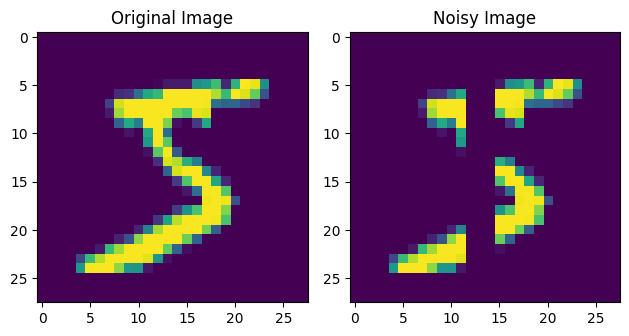

In [ ]:
# Choose an example image index
image_index = 0

# Get the original image and the noisy image
original_image = X_train[image_index]
noisy_image = X_train_noise_6k[image_index]

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image.squeeze())
plt.title('Original Image')

# Display the noisy image
plt.subplot(1, 2, 2)
plt.imshow(noisy_image.squeeze())
plt.title('Noisy Image')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
y_train_6k[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
#blocks definition
#input_size = 32 #ONLY FOR CIFAR DATASET

input_size = 28
def cnn_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,pooling=2):
    '''function that returns a cnn block composed of Conv-BatchNorm-ReLU-MaxPool layers'''
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.MaxPool2D(pool_size=(pooling,pooling))(x)
    return x


def resnet_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,r=True):
    '''function that returns a cnn block composed of two BatchNorm-ReLU-Convolution layers'''
    x = K.layers.BatchNormalization()(x_inp)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    if r:
        #interference Conv. layer in order to match the output dimensions
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x


def resnet(k=64):
    '''ResNet network creation'''
    images = K.layers.Input((input_size,input_size, 1))
    x = resnet_block(images,k,strides=1)
    n_blocks = 4
    for i in range(1, n_blocks):
            x = resnet_block(x, k* (2**i),strides=2)
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)


def cnn(k=64):
    '''CNN network creation'''
    images = K.layers.Input((input_size,input_size, 1))
    x = cnn_block(images,k,pooling=1)
    n_blocks = 4
    for i in range(1, n_blocks):
        if i == 3:
            x = cnn_block(x, k* (2**i),pooling=4)
            #x = cnn_block(x, k * (2**i),pooling=8) only for CIFAR DATASET
        else:
            x = cnn_block(x, k * (2**i))
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)

In [ ]:
net = cnn()
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512   

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(net, to_file='model.png')

In [ ]:
net = resnet()
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 28, 28, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 28, 28, 1)    0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 64)   640         activation_4[0][0]               
____________________________________________________________________________________________

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(net, to_file='model.png')

## MODEL-WISE DOUBLE DESCENT

In [ ]:
train_loss_noiseless = {}
test_loss_noiseless = {}
train_loss_noise = {}
test_loss_noise = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_noiseless = []
    error_test_noiseless = []
    error_train_noise = []
    error_test_noise = []
    s = '-'
    for _ in range(3):
        #noiseless
        net = cnn(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
        error_train_noiseless.append(history.history['loss'][-1])
        error_test_noiseless.append(history.history['val_loss'][-1])
        #noise
        net = cnn(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_noise_6k,y_train_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
        error_train_noise.append(history.history['loss'][-1])
        error_test_noise.append(history.history['val_loss'][-1])
    train_loss_noiseless[k] = np.mean(error_train_noiseless)
    test_loss_noiseless[k] = np.mean(error_test_noiseless)
    train_loss_noise[k] = np.mean(error_train_noise)
    test_loss_noise[k] = np.mean(error_test_noise)

    if k > 1:
        if list(test_loss_noiseless.values())[-1] >= list(test_loss_noiseless.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('NOISELESS: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noiseless[k],4),round(test_loss_noiseless[k],4),s))
    if k > 1:
        if list(test_loss_noise.values())[-1] >= list(test_loss_noise.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('25% NOISE: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noise[k],4),round(test_loss_noise[k],4),s))
    print()
    print()

<ipython-input-9-90230f62378b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1,21,1)):


  0%|          | 0/20 [00:00<?, ?it/s]

NOISELESS: k: 1, train_loss: 0.2211, test_loss: 0.3316 // -
25% NOISE: k: 1, train_loss: 0.2573, test_loss: 0.3359 // -


NOISELESS: k: 2, train_loss: 0.0199, test_loss: 0.2034 // -
25% NOISE: k: 2, train_loss: 0.0322, test_loss: 0.2445 // -


NOISELESS: k: 3, train_loss: 0.002, test_loss: 0.1481 // -
25% NOISE: k: 3, train_loss: 0.0027, test_loss: 0.1752 // -


NOISELESS: k: 4, train_loss: 0.0008, test_loss: 0.1363 // -
25% NOISE: k: 4, train_loss: 0.0008, test_loss: 0.1767 // +


NOISELESS: k: 5, train_loss: 0.0003, test_loss: 0.1109 // -
25% NOISE: k: 5, train_loss: 0.0005, test_loss: 0.1155 // -


NOISELESS: k: 6, train_loss: 0.0003, test_loss: 0.1083 // -
25% NOISE: k: 6, train_loss: 0.0003, test_loss: 0.1153 // -


NOISELESS: k: 7, train_loss: 0.0002, test_loss: 0.093 // -
25% NOISE: k: 7, train_loss: 0.0002, test_loss: 0.1053 // -


NOISELESS: k: 8, train_loss: 0.0001, test_loss: 0.0869 // -
25% NOISE: k: 8, train_loss: 0.0001, test_loss: 0.1027 // -


NOISELESS: k: 9, train_los

<ipython-input-10-0db3221d8d09>:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bx-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(list(test_loss_noiseless.keys()),list(test_loss_noiseless.values()),'bx-',marker = '.',linestyle='--',
<ipython-input-10-0db3221d8d09>:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bx-" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(list(test_loss_noiseless.keys()),list(test_loss_noiseless.values()),'bx-',marker = '.',linestyle='--',
<ipython-input-10-0db3221d8d09>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(list(test_loss_noiseless.keys()),list(test_loss_noiseless.values()),'bx-',marker = '.',linestyle='--',
<ipython-input-10-0db3221d8d09>:5: UserWarning: linestyle is red

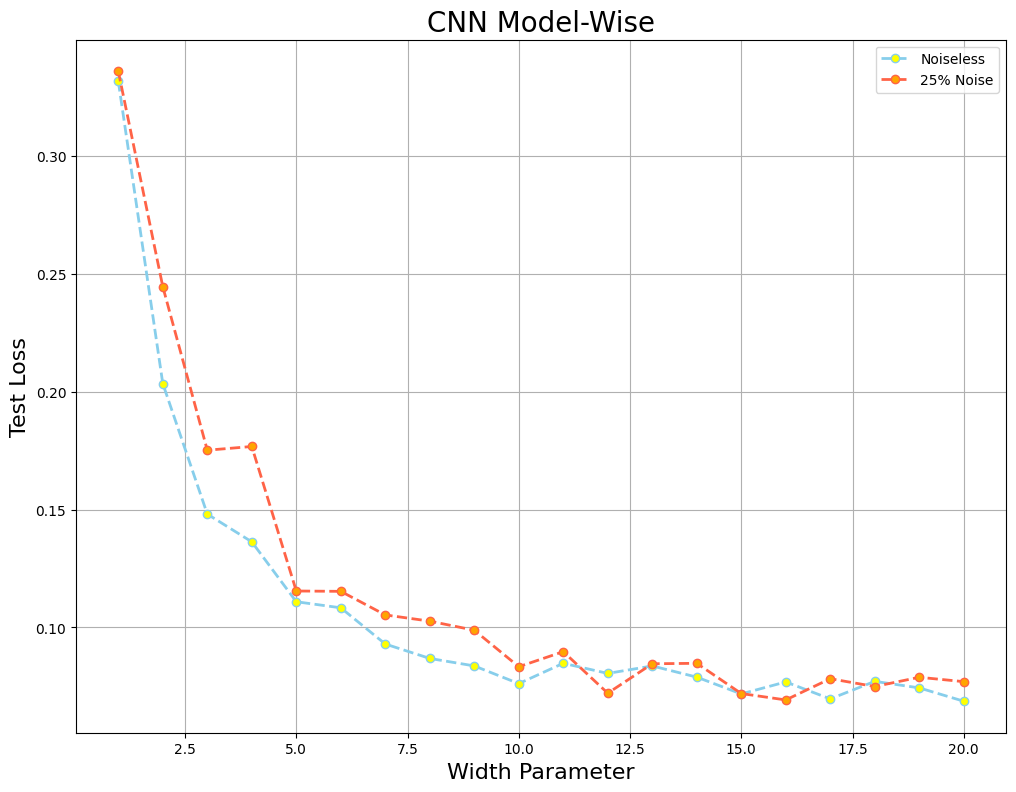

In [ ]:
# multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss_noiseless.keys()),list(test_loss_noiseless.values()),'bx-',marker = '.',linestyle='--',
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='Noiseless')
plt.plot(list(test_loss_noise.keys()),list(test_loss_noise.values()),'bx-',marker = '.',linestyle='--',
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='25% Noise')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN Model-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## SAMLE-WISE DOUBLE DESCENT

In [ ]:
train_loss_6k = {}
test_loss_6k = {}
train_loss_12k = {}
test_loss_12k = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_6k = []
    error_test_6k = []
    error_train_12k = []
    error_test_12k = []
    s = '-'
    for _ in range(3):
        #6k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_noise_6k,y_train_6k,batch_size=128,epochs=30,validation_data=(X_test,y_test),verbose=0)
        error_train_6k.append(history.history['loss'][-1])
        error_test_6k.append(history.history['val_loss'][-1])
        #12k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_noise_12k,y_train_12k,batch_size=128,epochs=30,validation_data=(X_test,y_test),verbose=0)
        error_train_12k.append(history.history['loss'][-1])
        error_test_12k.append(history.history['val_loss'][-1])
    train_loss_6k[k] = np.mean(error_train_6k)
    test_loss_6k[k] = np.mean(error_test_6k)
    train_loss_12k[k] = np.mean(error_train_12k)
    test_loss_12k[k] = np.mean(error_test_12k)

    if k > 1:
        if list(test_loss_6k.values())[-1] >= list(test_loss_6k.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('6k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_6k[k],4),round(test_loss_6k[k],4),s))
    if k > 1:
        if list(test_loss_12k.values())[-1] >= list(test_loss_12k.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('12k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_12k[k],4),round(test_loss_12k[k],4),s))
    print()
    print()

<ipython-input-6-dbf0ea5e937a>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1,21,1)):


  0%|          | 0/20 [00:00<?, ?it/s]

6k SAMPLES: k: 1, train_loss: 0.3607, test_loss: 0.443 // -
12k SAMPLES: k: 1, train_loss: 0.3139, test_loss: 0.3717 // -


6k SAMPLES: k: 2, train_loss: 0.0913, test_loss: 0.245 // -
12k SAMPLES: k: 2, train_loss: 0.0777, test_loss: 0.1498 // -


6k SAMPLES: k: 3, train_loss: 0.0189, test_loss: 0.1954 // -
12k SAMPLES: k: 3, train_loss: 0.0189, test_loss: 0.127 // -


6k SAMPLES: k: 4, train_loss: 0.0028, test_loss: 0.2147 // +
12k SAMPLES: k: 4, train_loss: 0.0059, test_loss: 0.144 // +




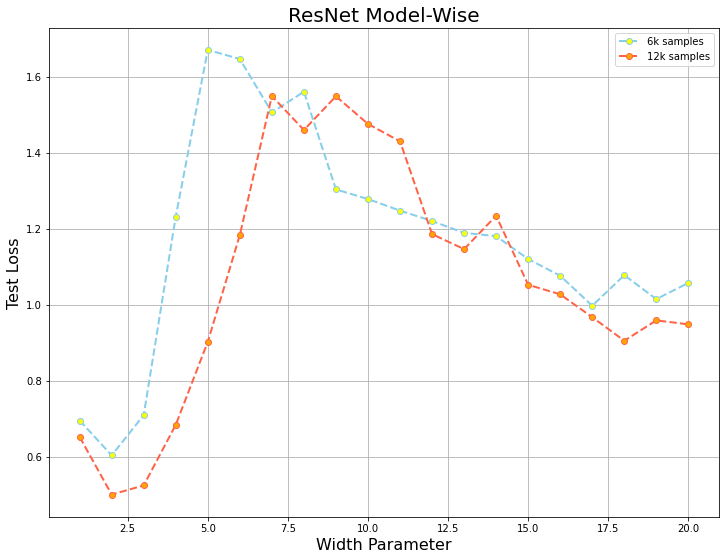

In [ ]:
# multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss_6k.keys()),list(test_loss_6k.values()),'bx-',marker = '.',linestyle='--',
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='6k samples')
plt.plot(list(test_loss_12k.keys()),list(test_loss_12k.values()),'bx-',marker = '.',linestyle='--',
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='12k samples')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('ResNet Model-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## EPOCH-WISE DOUBLE DESCENT

In [ ]:
train_loss = {}
test_loss = {}
for k in [3,12,48]:
    print()
    print('Model width parameter k: {}'.format(k))
    train_loss[k] = {}
    test_loss[k] = {}
    for e in tqdm_notebook(range(5,60,1)):
        error_train = []
        error_test = []
        s = '-'
        for _ in range(3):
            net = cnn(k)
            net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
            history = net.fit(X_train_noise_6k,y_train_6k,batch_size=128,epochs=e,validation_data=(X_test,y_test),verbose=0)
            error_train.append(history.history['loss'][-1])
            error_test.append(history.history['val_loss'][-1])
        train_loss[k][e] = np.mean(error_train)
        test_loss[k][e] = np.mean(error_test)
        if e > 5:
            if list(test_loss[k].values())[-1] >= list(test_loss[k].values())[-2]:
                s = '+'
            else:
                s = '-'
        print('Epoch: {}, train_loss: {}, test_loss: {} // {}'.format(e,round(train_loss[k][e],4),round(test_loss[k][e],4),s))


Model width parameter k: 3


<ipython-input-8-a8387965c1bc>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(5,60,1)):


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.5338, test_loss: 1.7255 // -
Epoch: 6, train_loss: 0.423, test_loss: 1.1178 // -
Epoch: 7, train_loss: 0.3783, test_loss: 0.8688 // -
Epoch: 8, train_loss: 0.3065, test_loss: 0.4566 // -
Epoch: 9, train_loss: 0.2449, test_loss: 0.4178 // -
Epoch: 10, train_loss: 0.2247, test_loss: 0.3245 // -
Epoch: 11, train_loss: 0.2265, test_loss: 0.3162 // -
Epoch: 12, train_loss: 0.1894, test_loss: 0.2488 // -
Epoch: 13, train_loss: 0.1786, test_loss: 0.2483 // -
Epoch: 14, train_loss: 0.1712, test_loss: 0.2394 // -
Epoch: 15, train_loss: 0.1588, test_loss: 0.2135 // -
Epoch: 16, train_loss: 0.1453, test_loss: 0.2054 // -
Epoch: 17, train_loss: 0.1472, test_loss: 0.2179 // +
Epoch: 18, train_loss: 0.1187, test_loss: 0.187 // -
Epoch: 19, train_loss: 0.1194, test_loss: 0.1874 // +
Epoch: 20, train_loss: 0.1027, test_loss: 0.1922 // +
Epoch: 21, train_loss: 0.1025, test_loss: 0.1866 // -
Epoch: 22, train_loss: 0.0925, test_loss: 0.1775 // -
Epoch: 23, train_loss: 0.0877, test

In [ ]:
import pandas as pd
df = pd.read_csv('resnet_epoch_wise.csv')
test_loss = {}
test_loss[3] = dict(zip(df['epoch'].values,df['3'].values))
test_loss[12] = dict(zip(df['epoch'].values,df['12'].values))
test_loss[48] = dict(zip(df['epoch'].values,df['48'].values))

In [ ]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')


y_av_3 = movingaverage(list(test_loss[3].values()), 5)
y_av_12 = movingaverage(list(test_loss[12].values()), 5)
y_av_48 = movingaverage(list(test_loss[48].values()), 5)

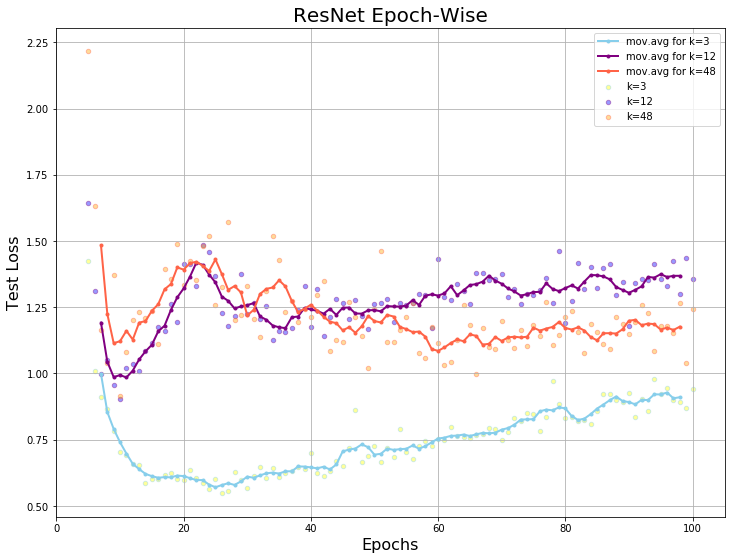

In [ ]:
#multiple line plot
plt.figure(figsize=(12,9))
plt.scatter(list(test_loss[3].keys()),list(test_loss[3].values()),marker = 'o',label='k=3',
            facecolor='yellow',color='skyblue',s=20,alpha=0.4)
plt.plot(list(test_loss[3].keys())[2:-2],y_av_3[2:-2],'bx-',marker = '.',linestyle='-', color='skyblue',
         linewidth=2,label='mov.avg for k=3')
plt.scatter(list(test_loss[12].keys()),list(test_loss[12].values()),marker = 'o',label='k=12',
            facecolor='blue',color='purple',s=20,alpha=0.4)
plt.plot(list(test_loss[12].keys())[2:-2],y_av_12[2:-2],'bx-',marker = '.',linestyle='-', color='purple',
         linewidth=2,label='mov.avg for k=12')
plt.scatter(list(test_loss[48].keys()),list(test_loss[48].values()),marker = 'o',label='k=48',
            facecolor='orange',color='tomato',s=20,alpha=0.4)
plt.plot(list(test_loss[48].keys())[2:-2],y_av_48[2:-2],'bx-',marker = '.',linestyle='-', color='tomato',
         linewidth=2,label='mov.avg for k=48')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('ResNet Epoch-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()